# Analyse et prédiction de la production d'un central photovoltaïque en tenant compte des variables climatiques et des productions des années précédentes

# Partie 1 : Analyse des données climatiques et historiques

# Importation des bibliothèques

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import calendar
import warnings
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics
from sklearn.pipeline import make_pipeline
import locale

In [2]:
warnings.filterwarnings('ignore')

# Prétraitement les données climatiques pertinentes et  les données historiques de production du central photovoltaïque

TEMPERATURE : Température à 2 mètres de MERRA-2 (exprimée en degrés Celsius).

IRRADIATION : Irradiance solaire descendante à ciel ouvert de CERES SYN1deg (Wh/m^2).

WINDSPEED: Vitesse du vent à 10 mètres MERRA-2 (m/s)

PRECIPITATION: Précipitations corrigées MERRA-2 (exprimées en millimètres par heure, mm/heure).

CERES - Clouds and the Earth's Radiant Energy System : CERES est un programme de la NASA qui vise à étudier et à mesurer les flux d'énergie radiative de la Terre, en particulier la manière dont les nuages et les aérosols interagissent avec le rayonnement solaire entrant et le rayonnement thermique sortant de la Terre. Les données collectées par CERES sont essentielles pour comprendre le bilan énergétique de la Terre et les variations du climat.

MERRA2 - Modern-Era Retrospective Analysis for Research and Applications, Version 2 : MERRA2 est un système de réanalyse de données météorologiques développé par la NASA. Il s'agit d'un modèle informatique sophistiqué qui intègre de nombreuses données observées pour produire des séries chronologiques cohérentes de données météorologiques rétrospectives sur une période prolongée. MERRA2 est utilisé pour analyser et reconstituer les conditions météorologiques passées, ce qui est essentiel pour de nombreuses recherches en climatologie et en sciences de l'atmosphère.

# Chargement des données

# temperature

In [3]:
temperature = pd.read_csv('C:\\Users\\Francial\\Notebook\\Data\\temperature.csv')

temperature.head()

,YEAR,MO,DY,HR,TEMPERATURE
0,2020,1,1,2,1.61
1,2020,1,1,3,1.55
2,2020,1,1,4,1.53
3,2020,1,1,5,1.53
4,2020,1,1,6,1.30


In [4]:
temperature['TEMPERATURE'].describe()

count    17542.00000
mean        10.59722
std          9.93962
min        -13.52000
25%          2.08000
50%          9.87000
75%         18.40000
max         36.25000
Name: TEMPERATURE, dtype: float64

# irradiation

In [5]:
irradiance = pd.read_csv('C:\\Users\\Francial\\Notebook\\Data\\irradiation.csv')
irradiance.head()

,YEAR,MO,DY,HR,IRRADIATION
0,2020,1,1,2,0.0
1,2020,1,1,3,0.0
2,2020,1,1,4,0.0
3,2020,1,1,5,0.0
4,2020,1,1,6,0.0


In [6]:
irradiance['IRRADIATION'].describe()

count    17542.000000
mean       152.829664
std        223.740558
min          0.000000
25%          0.000000
50%         10.215000
75%        252.012500
max        935.550000
Name: IRRADIATION, dtype: float64

# PRECIPITATION

In [7]:
precipitation = pd.read_csv('C:\\Users\\Francial\\Notebook\\Data\\precipitation.csv')

precipitation.head()

,YEAR,MO,DY,HR,PRECIPITATION
0,2020,1,1,2,0.00
1,2020,1,1,3,0.00
2,2020,1,1,4,0.00
3,2020,1,1,5,0.01
4,2020,1,1,6,0.02


In [8]:
precipitation['PRECIPITATION'].describe()

count    17542.000000
mean         0.067635
std          0.247101
min          0.000000
25%          0.000000
50%          0.000000
75%          0.030000
max         10.330000
Name: PRECIPITATION, dtype: float64

# Vitesse du vent

In [9]:
wind = pd.read_csv('C:\\Users\\Francial\\Notebook\\Data\\wind.csv')

wind.head()

,YEAR,MO,DY,HR,WINDSPEED
0,2020,1,1,2,8.99
1,2020,1,1,3,8.78
2,2020,1,1,4,8.99
3,2020,1,1,5,9.32
4,2020,1,1,6,9.37


In [10]:
wind['WINDSPEED'].describe()

count    17542.000000
mean         3.745011
std          2.001926
min          0.060000
25%          2.340000
50%          3.310000
75%          4.850000
max         18.990000
Name: WINDSPEED, dtype: float64

# Production Solaire

In [11]:
production = pd.read_excel('C:\\Users\\Francial\\Notebook\\Data\\production.xlsx')

production.head()

,DATE_TIME,Hours,Production
0,2020-01-01 02:00:00,02:00:00,0
1,2020-01-01 03:00:00,03:00:00,0
2,2020-01-01 04:00:00,04:00:00,0
3,2020-01-01 05:00:00,05:00:00,0
4,2020-01-01 06:00:00,06:00:00,0


In [12]:
production['Production'].describe()

count    17542.000000
mean       150.872991
std        221.692053
min          0.000000
25%          0.000000
50%          3.000000
75%        268.000000
max        869.000000
Name: Production, dtype: float64

# Nettoyage de données

Checking null values

In [13]:
irradiance.isnull().sum().sort_values(ascending=False)

YEAR           0
MO             0
DY             0
HR             0
IRRADIATION    0
dtype: int64

In [14]:
precipitation.isnull().sum().sort_values(ascending=False)

YEAR             0
MO               0
DY               0
HR               0
PRECIPITATION    0
dtype: int64

In [15]:
wind.isnull().sum().sort_values(ascending=False)

YEAR         0
MO           0
DY           0
HR           0
WINDSPEED    0
dtype: int64

In [16]:
temperature.isnull().sum().sort_values(ascending=False)

YEAR           0
MO             0
DY             0
HR             0
TEMPERATURE    0
dtype: int64

In [17]:
production.isnull().sum().sort_values(ascending=False)

DATE_TIME     0
Hours         0
Production    0
dtype: int64

# Deplacer chaque colones dans un seul dataframes

In [18]:
production['IRRADIATION'] = irradiance['IRRADIATION']

In [19]:
production['PRECIPITATION'] = precipitation['PRECIPITATION']

In [20]:
production['TEMPERATURE'] = temperature['TEMPERATURE']

In [21]:
production['WINDSPEED'] = wind['WINDSPEED']

In [22]:
donne = production.copy()
del production

In [23]:
donne.head()

,DATE_TIME,Hours,Production,IRRADIATION,PRECIPITATION,TEMPERATURE,WINDSPEED
0,2020-01-01 02:00:00,02:00:00,0,0.0,0.00,1.61,8.99
1,2020-01-01 03:00:00,03:00:00,0,0.0,0.00,1.55,8.78
2,2020-01-01 04:00:00,04:00:00,0,0.0,0.00,1.53,8.99
3,2020-01-01 05:00:00,05:00:00,0,0.0,0.01,1.53,9.32
4,2020-01-01 06:00:00,06:00:00,0,0.0,0.02,1.30,9.37


In [24]:
donne['Production'].describe()

count    17542.000000
mean       150.872991
std        221.692053
min          0.000000
25%          0.000000
50%          3.000000
75%        268.000000
max        869.000000
Name: Production, dtype: float64

In [25]:
donne["DATE"] = pd.to_datetime(donne["DATE_TIME"]).dt.date # add new column with date
donne["TIME"] = pd.to_datetime(donne["DATE_TIME"]).dt.time # add new column with time

In [26]:
donne['HEURE'] = precipitation['HR']

In [27]:
donne["DATE_STR"] = donne["DATE"].astype(str)

In [28]:
# final dataset
donne.head(20)

,DATE_TIME,Hours,Production,IRRADIATION,PRECIPITATION,TEMPERATURE,WINDSPEED,DATE,TIME,HEURE,DATE_STR
0,2020-01-01 02:00:00,02:00:00,0,0.00,0.00,1.61,8.99,2020-01-01,02:00:00,2,2020-01-01
1,2020-01-01 03:00:00,03:00:00,0,0.00,0.00,1.55,8.78,2020-01-01,03:00:00,3,2020-01-01
2,2020-01-01 04:00:00,04:00:00,0,0.00,0.00,1.53,8.99,2020-01-01,04:00:00,4,2020-01-01
3,2020-01-01 05:00:00,05:00:00,0,0.00,0.01,1.53,9.32,2020-01-01,05:00:00,5,2020-01-01
4,2020-01-01 06:00:00,06:00:00,0,0.00,0.02,1.30,9.37,2020-01-01,06:00:00,6,2020-01-01
5,2020-01-01 07:00:00,07:00:00,0,0.00,0.01,0.78,8.61,2020-01-01,07:00:00,7,2020-01-01
6,2020-01-01 08:00:00,08:00:00,32,23.78,0.01,0.28,7.62,2020-01-01,08:00:00,8,2020-01-01
7,2020-01-01 09:00:00,09:00:00,164,73.82,0.01,0.87,8.29,2020-01-01,09:00:00,9,2020-01-01
8,2020-01-01 10:00:00,10:00:00,287,163.12,0.04,1.69,9.50,2020-01-01,10:00:00,10,2020-01-01
9,2020-01-01 11:00:00,11:00:00,367,192.46,0.03,2.30,10.89,2020-01-01,11:00:00,11,2020-01-01


In [29]:
donne.describe()

,Production,IRRADIATION,PRECIPITATION,TEMPERATURE,WINDSPEED,HEURE
count,17542.000000,17542.000000,17542.000000,17542.00000,17542.000000,17542.000000
mean,150.872991,152.829664,0.067635,10.59722,3.745011,11.501254
std,221.692053,223.740558,0.247101,9.93962,2.001926,6.921780
min,0.000000,0.000000,0.000000,-13.52000,0.060000,0.000000
25%,0.000000,0.000000,0.000000,2.08000,2.340000,6.000000
50%,3.000000,10.215000,0.000000,9.87000,3.310000,12.000000
75%,268.000000,252.012500,0.030000,18.40000,4.850000,17.750000
max,869.000000,935.550000,10.330000,36.25000,18.990000,23.000000


# Vérification des valeurs manquantes.

In [30]:
donne.isnull().sum().sort_values(ascending=False)

DATE_TIME        0
Hours            0
Production       0
IRRADIATION      0
PRECIPITATION    0
TEMPERATURE      0
WINDSPEED        0
DATE             0
TIME             0
HEURE            0
DATE_STR         0
dtype: int64

- Il n'a pas de valeur manquante dans le jeu de donnée;

# Vérification des valeurs aberrantes.

In [31]:
numeric_columns = donne.select_dtypes(include=[np.number]).columns
def find_outliers(column_donne):
    q1 = np.percentile(column_donne, 25)
    q3 = np.percentile(column_donne, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = column_donne[(column_donne < lower_bound) | (column_donne > upper_bound)]
    return outliers
outliers_dict = {}
for column in numeric_columns:
    outliers_dict[column] = find_outliers(donne[column])
for column, outliers in outliers_dict.items():
    if len(outliers) > 0:
        print(f"Outliers in {column}:")
        max_value = max(outliers)
        min_value = min(outliers)
        print(f"Valeur maximum: {max_value}, Valeur minimum: {min_value}")
    else:
        print(f"No outliers in {column}")
    print()

Outliers in Production:
Valeur maximum: 869, Valeur minimum: 671

Outliers in IRRADIATION:
Valeur maximum: 935.55, Valeur minimum: 630.62

Outliers in PRECIPITATION:
Valeur maximum: 10.33, Valeur minimum: 0.08

No outliers in TEMPERATURE

Outliers in WINDSPEED:
Valeur maximum: 18.99, Valeur minimum: 8.62

No outliers in HEURE



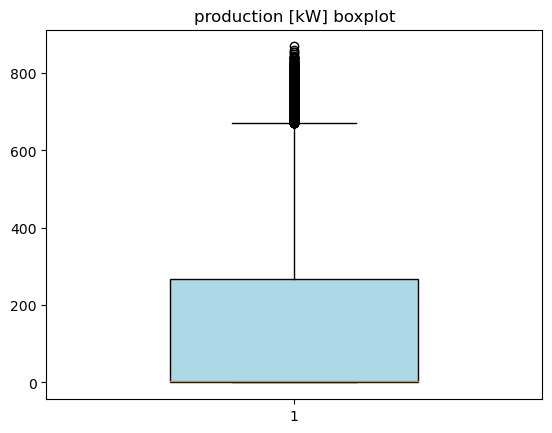

In [32]:
plt.boxplot(donne['Production'], vert=True, widths=0.5, patch_artist=True, boxprops=dict(facecolor='lightblue'))
plt.title('production [kW] boxplot')
plt.show()

Il est important de noter que les valeurs aberrantes que nous avons identifiées ne sont pas
nécessairement des données incorrectes, mais plutôt des valeurs exceptionnellement élevées.
Ces valeurs peuvent être expliquées par divers facteurs, tels que des conditions météorologiques exceptionnelles ou d’autres variables externes.

Pour une analyse plus approfondie des valeurs potentiellement incorrectes ou capturées par
erreur, nous avons également généré un graphique de dispersion. Ce graphique nous permettra d’identifier plus précisément les valeurs anormales ou incohérentes dans nos données.

In [38]:
fig = px.scatter(donne, x="HEURE", y="Production", color="DATE_STR")
fig.update_traces(marker=dict(size=5, opacity=0.7), selector=dict(mode='markers'))
fig.update_layout(yaxis_title="Production [kW]")
fig.show()

# on remplace les valeur anormales par la valeur 0

In [39]:
# Masque et remplacement pour la date "2020-08-18" et une production de 506
mask1 = (donne["DATE_STR"] == "2020-08-18") & (donne["Production"] == 506)
donne.loc[mask1, "Production"] = 0
mask2 = (donne["DATE_STR"] == "2020-03-30") & (donne["Production"] == 581)
donne.loc[mask2, "Production"] = 0
mask1 = (donne["DATE_STR"] == "2020-08-17") & (donne["Production"] == 506)
donne.loc[mask1, "Production"] = 0
mask1 = (donne["DATE_STR"] == "2020-08-20") & (donne["Production"] == 229)
donne.loc[mask1, "Production"] = 0
mask1 = (donne["DATE_STR"] == "2020-12-04") & (donne["Production"] == 208)
donne.loc[mask1, "Production"] = 0
mask1 = (donne["DATE_STR"] == "2020-08-18") & (donne["Production"] == 368)
donne.loc[mask1, "Production"] = 0
mask1 = (donne["DATE_STR"] == "2020-12-05") & (donne["Production"] == 104)
donne.loc[mask1, "Production"] = 0
mask1 = (donne["DATE_STR"] == "2020-06-26") & (donne["Production"] == 76)
donne.loc[mask1, "Production"] = 0
mask1 = (donne["DATE_STR"] == "2020-06-25") & (donne["Production"] == 76)
donne.loc[mask1, "Production"] = 0
mask1 = (donne["DATE_STR"] == "2020-08-20") & (donne["Production"] == 114)
donne.loc[mask1, "Production"] = 0
mask1 = (donne["DATE_STR"] == "2021-05-03") & (donne["Production"] == 201)
donne.loc[mask1, "Production"] = 0
mask1 = (donne["DATE_STR"] == "2021-05-03") & (donne["Production"] == 100)
donne.loc[mask1, "Production"] = 0
mask1 = (donne["DATE_STR"] == "2020-06-01") & (donne["Production"] == 50)
donne.loc[mask1, "Production"] = 0
mask1 = (donne["DATE_STR"] == "2021-02-19") & (donne["Production"] == 23)
donne.loc[mask1, "Production"] = 0
mask1 = (donne["DATE_STR"] == "2021-02-18") & (donne["Production"] == 23)
donne.loc[mask1, "Production"] = 0
mask1 = (donne["DATE_STR"] == "2021-11-03") & (donne["Production"] == 21)
donne.loc[mask1, "Production"] = 0
mask1 = (donne["DATE_STR"] == "2021-11-02") & (donne["Production"] == 21)
donne.loc[mask1, "Production"] = 0
mask1 = (donne["DATE_STR"] == "2020-06-01") & (donne["Production"] == 25)
donne.loc[mask1, "Production"] = 0
mask1 = (donne["DATE_STR"] == "2021-11-03") & (donne["Production"] == 10)
donne.loc[mask1, "Production"] = 0
mask1 = (donne["DATE_STR"] == "2020-06-26") & (donne["Production"] == 38)
donne.loc[mask1, "Production"] = 0

# Distribution quotidienne de la production d’énergie solaire en présence des valeurs aberrantes

In [41]:
fig = px.scatter(donne, x="HEURE", y="Production", color = "DATE_STR")
fig.update_traces(marker=dict(size=5, opacity=0.7), selector=dict(mode='markers'))
fig.update_layout(yaxis_title="Production [kW]")
fig.show()

# profil hebdomadaire

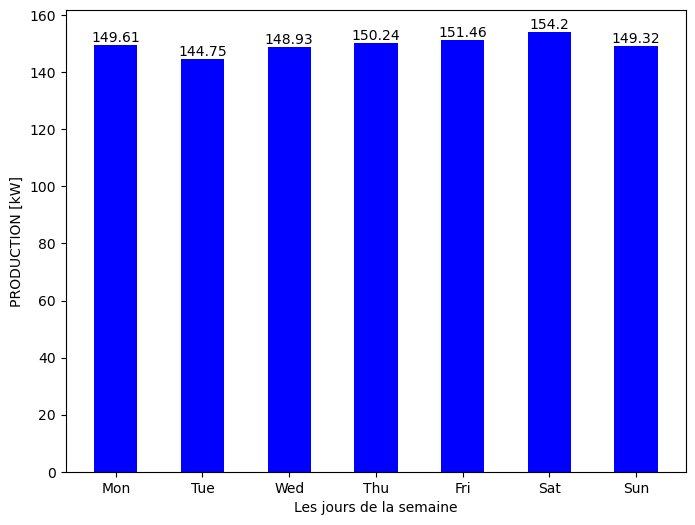

In [44]:
donne['day_of_week'] = donne.DATE_TIME.dt.dayofweek
daily_average = donne.groupby('day_of_week')['Production'].mean()
fig = plt.figure(figsize=(8, 6))
bars = plt.bar(daily_average.index, daily_average, width=0.5, color='blue')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')
day_names = [calendar.day_abbr[i] for i in range(7)]
plt.xlabel('Les jours de la semaine')
plt.ylabel('PRODUCTION [kW]')
plt.xticks(range(7), day_names)
plt.show()

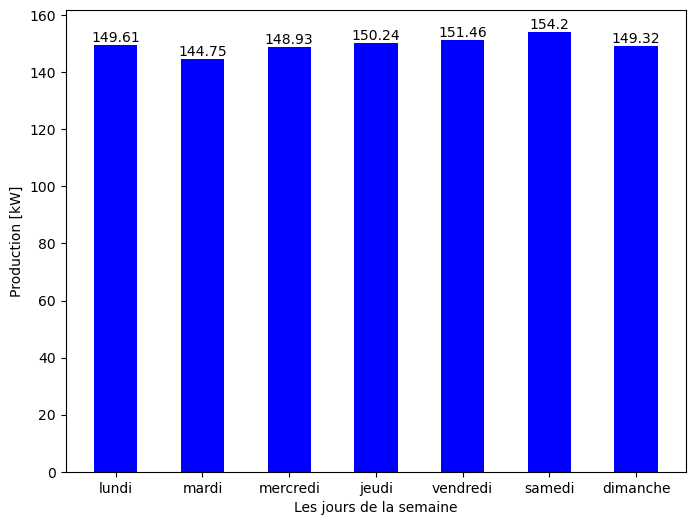

In [47]:
# Définir la locale en français
locale.setlocale(locale.LC_ALL, 'fr_FR')

donne['day_of_week'] = donne.DATE_TIME.dt.dayofweek
daily_average = donne.groupby('day_of_week')['Production'].mean()
fig = plt.figure(figsize=(8, 6))
bars = plt.bar(daily_average.index, daily_average, width=0.5, color='blue')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

# Obtenir les jours de la semaine en français
day_names = [calendar.day_name[i] for i in range(7)]

plt.xlabel('Les jours de la semaine')
plt.ylabel('Production [kW]')
plt.xticks(range(7), day_names)
plt.show()

# production moyenne pour chaque mois de l'année

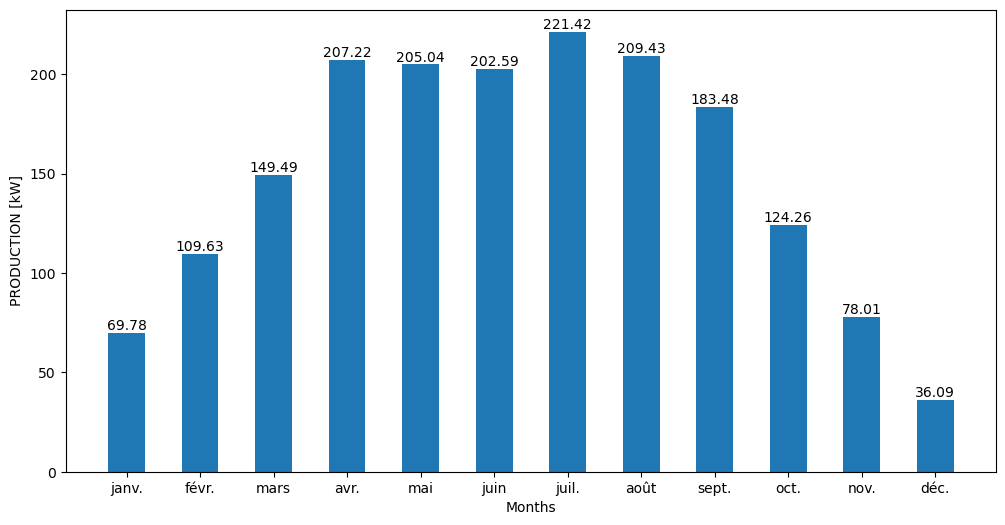

In [48]:
monthly_average = donne.groupby(donne.DATE_TIME.dt.month)['Production'].mean()
fig = plt.figure(figsize=(12, 6))
plt.bar(monthly_average.index, monthly_average, width=0.5)
month_names = [calendar.month_abbr[i] for i in range(1, 13)]
plt.xlabel('Months')
plt.ylabel('PRODUCTION [kW]')
plt.xticks(range(1, 13), month_names)
max_value = monthly_average.max()
for i, v in enumerate(monthly_average):
    plt.text(i + 1, v, f'{v:.2f}', ha='center', va='bottom', fontsize=10)
plt.show()


Pour l'irradiation

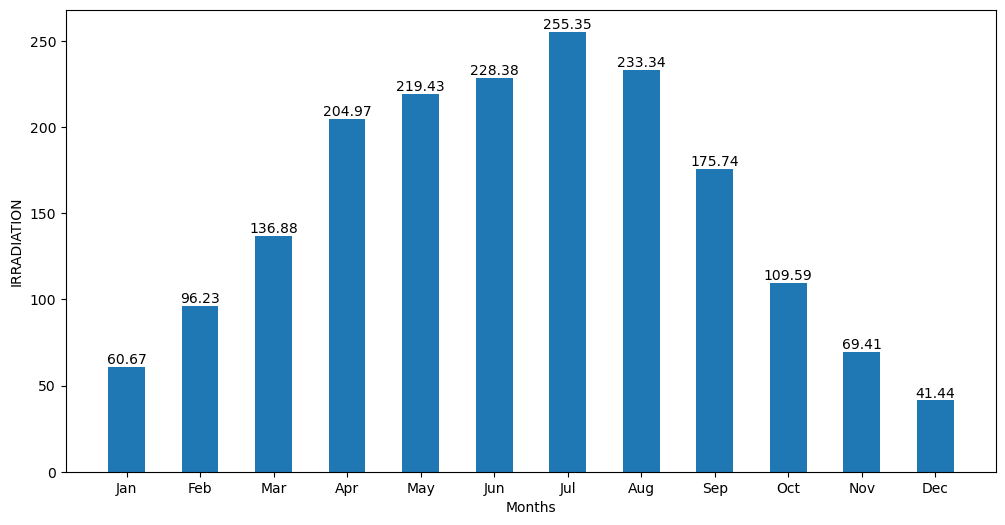

In [38]:
monthly_average = donne.groupby(donne.DATE_TIME.dt.month)['IRRADIATION'].mean()
fig = plt.figure(figsize=(12, 6))
plt.bar(monthly_average.index, monthly_average, width=0.5)
month_names = [calendar.month_abbr[i] for i in range(1, 13)]
plt.xlabel('Months')
plt.ylabel('IRRADIATION')
plt.xticks(range(1, 13), month_names)
max_value = monthly_average.max()
for i, v in enumerate(monthly_average):
    plt.text(i + 1, v, f'{v:.2f}', ha='center', va='bottom', fontsize=10)
plt.show()


# Convertir la colonne 'Date' en datetime

In [39]:
donne['DATE'] = pd.to_datetime(donne['DATE'])
donne.set_index('DATE', inplace=True)

# Production pour chaque mois de l'année

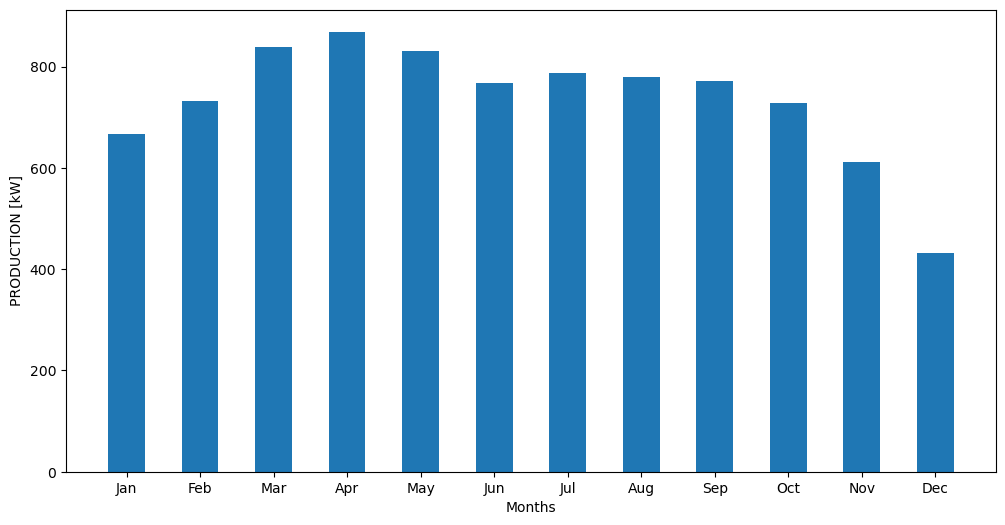

In [40]:
fig = plt.figure(figsize=(12, 6))
plt.bar(donne.DATE_TIME.dt.month, donne.Production, width=0.5)
month_names = [calendar.month_abbr[i] for i in range(1, 13)]
plt.xlabel('Months')
plt.ylabel('PRODUCTION [kW]')
plt.xticks(range(1, 13), month_names)
plt.show()

# Variation de la production mensuelle moyenne:

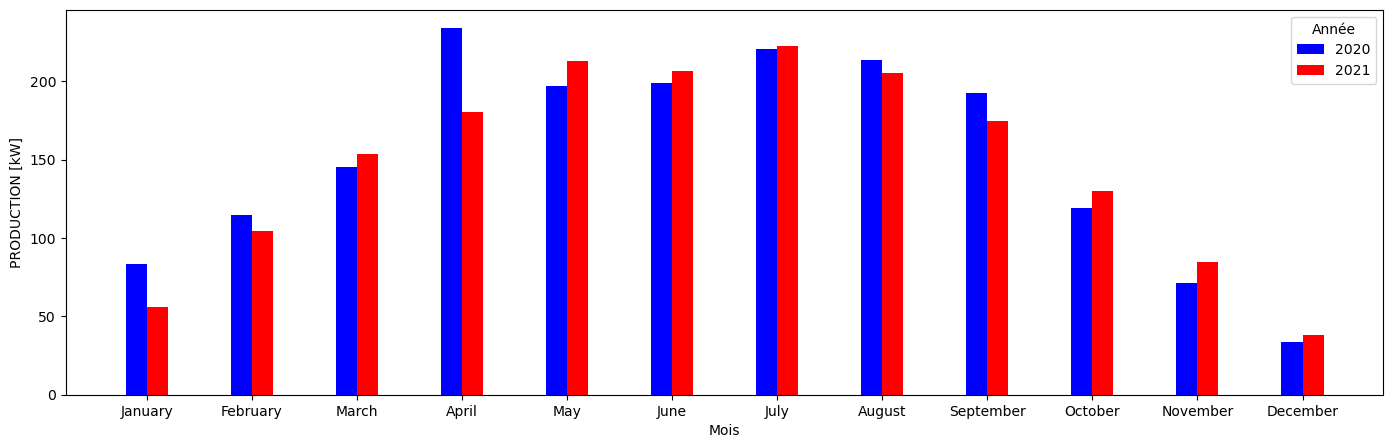

In [41]:
donne['MONTH'] = donne['DATE_TIME'].dt.strftime('%B')
donne['YEAR'] = donne['DATE_TIME'].dt.year
years_to_plot = [2020, 2021]
filtered_data = donne[donne['YEAR'].isin(years_to_plot)]
month_order = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
filtered_data['MONTH'] = pd.Categorical(filtered_data['MONTH'], categories=month_order, ordered=True)
monthly_production = filtered_data.groupby(['YEAR', 'MONTH'])['Production'].mean().unstack(level=0)
colors = {2021: 'red', 2020: 'blue'}
plt.figure(figsize=(17, 5))
width = 0.2
months = range(len(month_order))
for i, year in enumerate(years_to_plot):
    positions = [month + (i - 0.5) * width for month in months]
    plt.bar(positions, monthly_production[year], width=width, label=str(year), color=colors[year])
plt.xlabel('Mois')
plt.ylabel('PRODUCTION [kW]')
plt.xticks(ticks=months, labels=month_order, rotation=0)
plt.legend(title='Année')
plt.show()

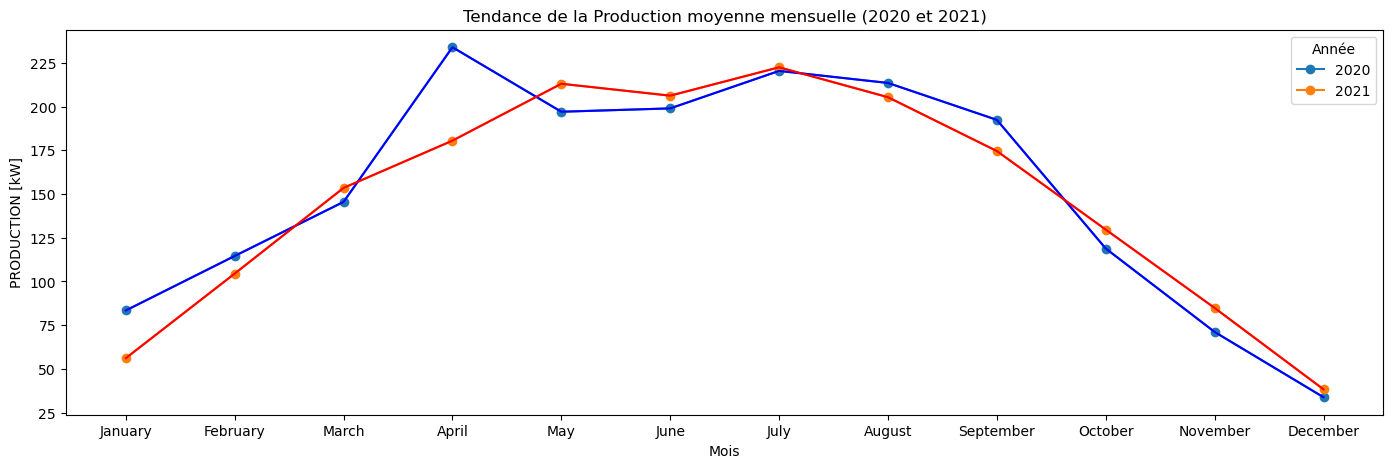

In [42]:
donne['MONTH'] = donne['DATE_TIME'].dt.strftime('%B')
donne['YEAR'] = donne['DATE_TIME'].dt.year
years_to_plot = [2020, 2021]
filtered_data = donne[donne['YEAR'].isin(years_to_plot)]
month_order = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
filtered_data['MONTH'] = pd.Categorical(filtered_data['MONTH'], categories=month_order, ordered=True)
monthly_production = filtered_data.groupby(['YEAR', 'MONTH'])['Production'].mean().unstack(level=0)
plt.figure(figsize=(17, 5))
for year in years_to_plot:
    plt.plot(monthly_production.index, monthly_production[year], marker='o', label=str(year))
colors = {2021: 'red', 2020: 'blue'}
for year, data in monthly_production.items():
    plt.plot(data, color=colors.get(year))
plt.xlabel('Mois')
plt.ylabel('PRODUCTION [kW]')
plt.title('Tendance de la Production moyenne mensuelle (2020 et 2021)')
plt.xticks(rotation=0)
plt.legend(title='Année')
plt.show()

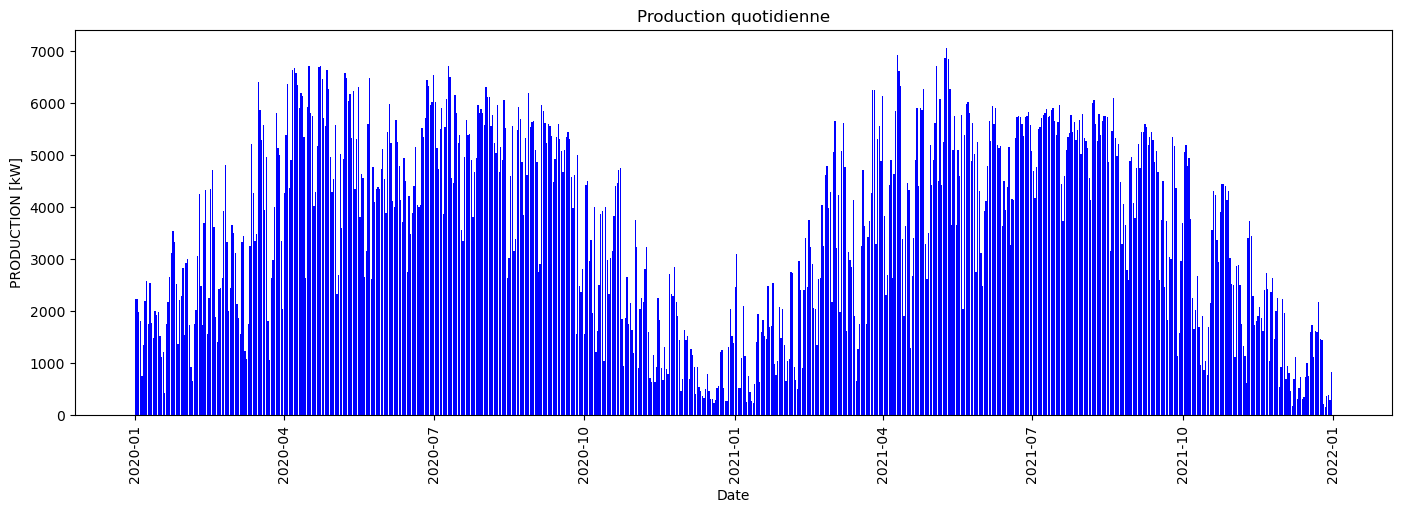

In [43]:
daily_dc = donne.groupby('DATE')['Production'].sum()
daily_dc = daily_dc.sort_values(ascending=False)
plt.figure(figsize=(17, 5))
plt.bar(daily_dc.index, daily_dc.values, color = "blue")
plt.xlabel('Date')
plt.ylabel('PRODUCTION [kW]')
plt.title('Production quotidienne')
plt.xticks(rotation=90)
plt.show()

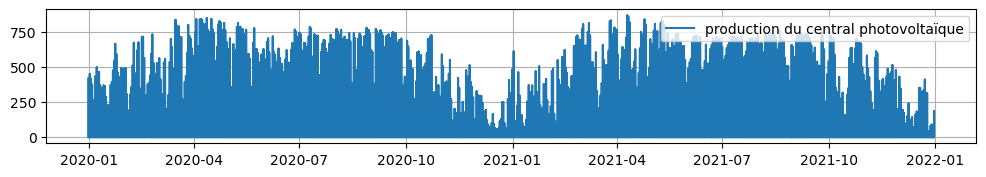

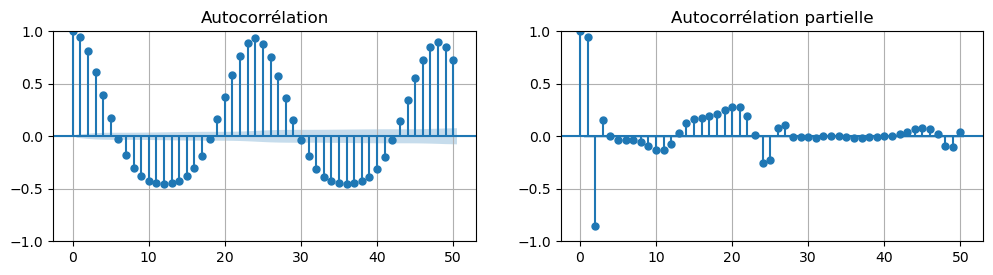

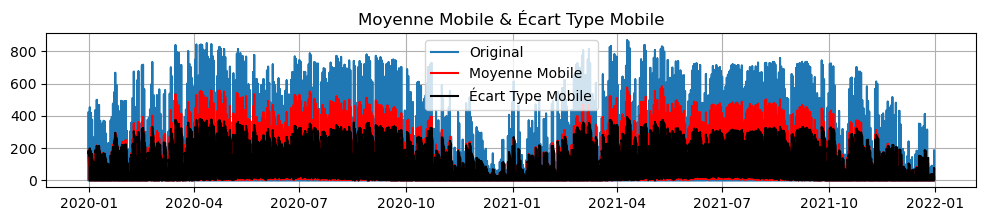

In [44]:
plt.figure(figsize=(12, 8))
plt.subplot(4, 1, 1)
plt.grid(True)
plt.plot(donne['Production'], label='production du central photovoltaïque')
plt.legend()
rolling_window = 30
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.grid(True)
plot_acf(donne['Production'], lags=50, ax=plt.gca(), title='Autocorrélation')
plt.subplot(2, 2, 2)
plt.grid(True)
plot_pacf(donne['Production'], lags=50, ax=plt.gca(), title='Autocorrélation partielle')
rm = donne['Production'].rolling(window=12).mean()
rs = donne['Production'].rolling(window=12).std()
plt.figure(figsize=(12, 2))
plt.grid(True)
plt.plot(donne['Production'], label='Original')
plt.plot(rm, color='red', label='Moyenne Mobile')
plt.plot(rs, color='black', label='Écart Type Mobile')
plt.legend()
plt.title('Moyenne Mobile & Écart Type Mobile')
plt.show()

# Analyse des corrélations entre les variables climatiques et la production d'électricité

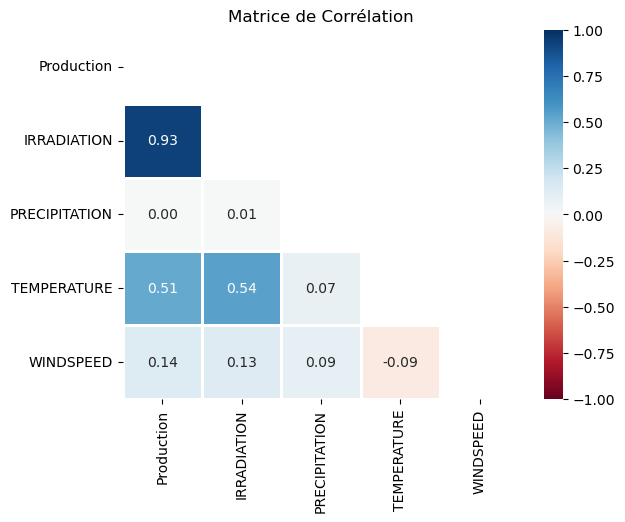

In [45]:
selected_columns = ["Production", "IRRADIATION", "PRECIPITATION", "TEMPERATURE", "WINDSPEED"]
selected_data = donne[selected_columns]
mask = np.triu(np.ones_like(selected_data.corr(), dtype=bool))
sns.heatmap(selected_data.corr(), mask=mask, center=0, cmap='RdBu', linewidths=1, annot=True, fmt='.2f', vmin=-1, vmax=1)
plt.title('Matrice de Corrélation')
plt.show()

*   Corrélation Négative : Si la corrélation entre deux variables est négative (proche de -1), cela signifie que lorsque l'une des variables augmente, l'autre a tendance à diminuer. 

*   Corrélation Positive : Si la corrélation entre deux variables est positive (proche de 1), cela signifie que lorsque l'une des variables augmente, l'autre a tendance à augmenter également.

*   Corrélation Faible : Une corrélation proche de 0 indique une faible relation linéaire entre les variables. Cela signifie que les variations d'une variable ne sont pas fortement associées aux variations de l'autre variable.

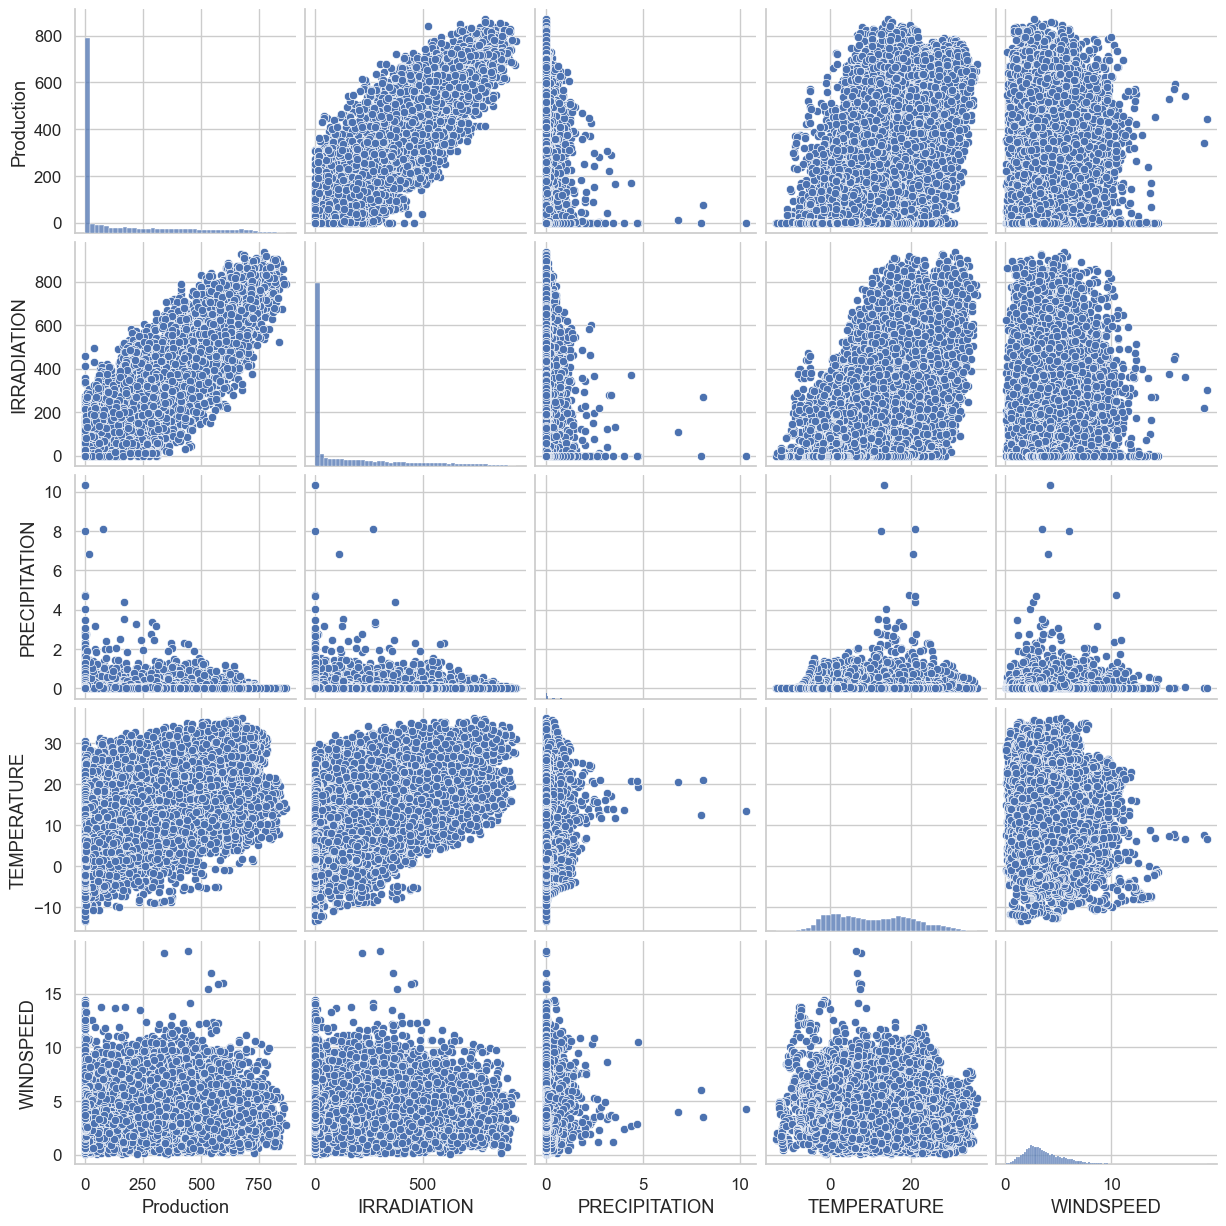

In [46]:
sns.set(style='whitegrid', font_scale=1.1, rc={"figure.figsize": [15, 5]})
cols_pair = ["Production", "IRRADIATION", "PRECIPITATION", "TEMPERATURE", "WINDSPEED"]
fig_pair = sns.pairplot(donne[cols_pair])
plt.show()